In [1]:
a = rand(10^7)

10000000-element Array{Float64,1}:
 0.8333894957597299
 0.446599964646726
 0.7055742621096328
 0.6648488411140399
 0.22336072168549292
 0.42249775557940894
 0.6118269321125684
 0.61178054828362
 0.23189568926322757
 0.9692644735325537
 0.02053003209521953
 0.24013930934503125
 0.8161411164938797
 ⋮
 0.8076917131566257
 0.45420309857365804
 0.08678212287693876
 0.23014215684572692
 0.6964946627547774
 0.31899136772938164
 0.49220710773430865
 0.04055597772214248
 0.32493946781435845
 0.4377033976194966
 0.6041429923212676
 0.9645351767846904

In [2]:
sum(a)

5.000142948438107e6

In [3]:
using Pkg
Pkg.add("BenchmarkTools")
using BenchmarkTools
using Libdl

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [4]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for(size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""
const Clib = tempname() #make a tmp file
#compile to shared lib by gcc
open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [5]:
c_sum(a)

5.000142948438451e6

In [6]:
c_sum(a) ≈ sum(a) # \approx <TAB>

true

In [7]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


In [8]:
c_bench = @benchmark c_sum($a)

BechmarkTools.Trial: 452 samples with 1 evaluations.
 Range (min … max):  10.325 ms …  12.791 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.979 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.058 ms ± 411.948 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▂▅▂▃█▇▁▅▁▇▅▃▄▃▅▅▁▁                                      
  ▃▃▃▄▄▄██████████████████▅▆▆█▆▅▆▇▇▄▄▄▄▅▄▅▃▄▃▃▁▁▃▃▃▃▁▃▃▃▁▁▁▁▁▃ ▄
  10.3 ms         Histogram: frequency by time         12.5 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [9]:
println("Min Time : $(minimum(c_bench.times) / 1e6)")

Min Time : 10.324836


In [10]:
using Plots
using Statistics
gr()

Plots.GRBackend()

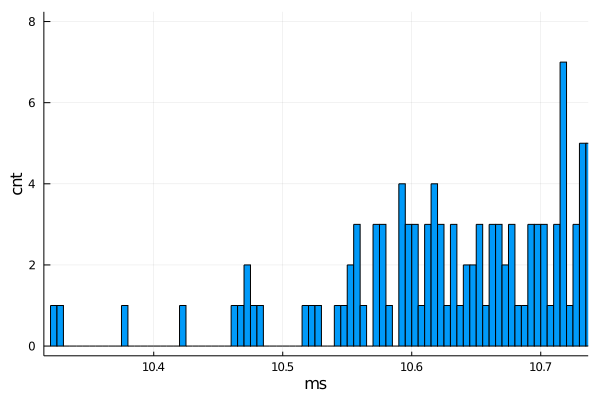

In [11]:
t = c_bench.times / 1e6
m, sig = minimum(t), std(t)

histogram(t, bins=500, xlim=(m-0.01, m+sig), xlabel="ms", ylabel="cnt", label="")

In [12]:
Pkg.add("PyCall")
using PyCall

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [13]:
apy = PyCall.array2py(a)
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [14]:
pysum(a)

5.000142948438451e6

In [15]:
pysum(a) ≈ sum(a)

true

In [16]:
py_bench = @benchmark $pysum($apy)

BechmarkTools.Trial: 116 samples with 1 evaluations.
 Range (min … max):  41.083 ms … 48.517 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     42.962 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   43.311 ms ±  1.553 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ██▄▇  ▁ ▁▅    ▂                                       
  ▃▃▃▁▃▃▆████▅██▃██▆▅█▃█▅▃▅▅▆▃▃▁▃▆▁▅▆▁▁▁▃▃▁▃▁▁▁▁▃▁▁▁▁▁▃▁▅▁▁▁▅ ▃
  41.1 ms         Histogram: frequency by time        48.2 ms <

 Memory estimate: 48 bytes, allocs estimate: 3.

In [17]:
minimum(py_bench.times)/1e6

41.082719

In [18]:
Pkg.add("Conda")
using Conda
Conda.add("numpy")

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /home/sanglyul/.julia/packages/Conda/sNGum/src/Conda.jl:128


Solving environment: ...working... done

# All requested packages already installed.



In [19]:
numpy_sum = pyimport("numpy")["sum"]
apy_np = PyObject(a)
py_np_bench = @benchmark $numpy_sum($apy_np)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[19]:1
└ @ Core In[19]:1


BechmarkTools.Trial: 1250 samples with 1 evaluations.
 Range (min … max):  3.785 ms …   5.639 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.907 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.994 ms ± 269.408 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▇█▆▆▄▁                                                      
  ███████▇▇▇▅▅▄▅▄▃▃▃▃▂▂▃▃▂▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▂▁▂▂▂▂▂▂▂ ▃
  3.78 ms         Histogram: frequency by time        5.22 ms <

 Memory estimate: 48 bytes, allocs estimate: 3.

In [22]:
isapprox(numpy_sum(apy_np), sum(a))

true

In [23]:
minimum(py_np_bench.times)/1e6

3.784933

In [24]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s += x
    return s
"""
sum_py = py"py_sum"

PyObject <function py_sum at 0x7f676c0c5790>

In [25]:
py_hand = @benchmark $sum_py($apy)

BechmarkTools.Trial: 19 samples with 1 evaluations.
 Range (min … max):  256.284 ms … 278.475 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     261.180 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   263.662 ms ±   5.974 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

        █                     ▄                                  
  ▆▁▁▁▆▁█▁▁▆▆▁▆▆▁▁▆▁▁▁▁▁▁▁▁▁▁▁█▁▆▁▆▁▁▁▁▆▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  256 ms           Histogram: frequency by time          278 ms <

 Memory estimate: 48 bytes, allocs estimate: 3.

In [26]:
isapprox(sum_py(apy), sum(a))

true

In [27]:
minimum(py_hand.times)/1e6

256.283881

In [28]:
@which sum(a)

sum(a::AbstractArray; dims) in Base at reducedim.jl:652

In [29]:
j_bench = @benchmark sum($a)

BechmarkTools.Trial: 855 samples with 1 evaluations.
 Range (min … max):  4.733 ms …   7.693 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.804 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.829 ms ± 467.090 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                         ▁█▃▃▄▃                                
  ▂▁▂▄▃▃▆▇▅▄▅▄▄▃▄▃▄▃▃▃▄▅▄███████▇██▆▆▅▆▇▃▅▆▅▅▅▄▅▅▄▄▄▃▃▂▃▃▂▂▂▂ ▄
  4.73 ms         Histogram: frequency by time        6.99 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [30]:
minimum(j_bench.times)/1e6

4.733334

In [31]:
function mysum(A)
    s = 0.0
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [32]:
j_hand_bench = @benchmark(mysum($a))

BechmarkTools.Trial: 450 samples with 1 evaluations.
 Range (min … max):  10.484 ms …  14.271 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.017 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.105 ms ± 464.480 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂▃ ▅▆▇▃▇▄▇▄▄▆▇▁█▃▃▂▃                                        
  ▆▇████████████████████▆█▆▅▅▆█▆▄▆▅▅▆▅▄▄▃▃▄▁▃▃▅▁▁▃▃▁▃▃▁▁▃▁▃▁▁▄ ▅
  10.5 ms         Histogram: frequency by time         12.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [33]:
minimum(j_hand_bench.times)/1e6

10.483795